# カテゴリ変数分析 v2

**目的**: カテゴリカル特徴量の分析とTarget Encodingの検討

**このノートブックで行うこと**:
1. カーディナリティ分類
2. Target Encoding効果の予測
3. カテゴリ別ターゲット統計量の確認

## セットアップ

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# フォント設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# テスト済み関数のimport
from eda.categorical import (
    classify_cardinality,
    calculate_target_encoding_potential,
    get_category_target_stats
)

print("✓ セットアップ完了")

✓ セットアップ完了


## 1. データ読み込み

In [2]:
# データ読み込み（DataLoaderパターン）
from data.loader import DataLoader
from utils.config import load_config

data_config = load_config("data")
loader = DataLoader(data_config)
train = loader.load_train()

print(f"訓練データ: {train.shape}")
train.head()

訓練データ: (363924, 149)


target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,…,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
i64,i64,i64,i64,str,str,i64,str,str,str,str,i64,str,f64,f64,i64,f64,f64,i64,i64,i64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,str,i64,…,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,str,i64,str,str,i64,str,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,str,str
201901,13980000,206271,1,"""2014-06-27 21:09:41""","""2019-01-24 00:10:08""",4,null,null,"""桑名市東正和台7丁目10-11""",null,null,"""三重県桑名市東正和台7丁目10-11""",136.637467,35.047688,1,106.82,null,2,null,199204,188.490005,188.490005,null,null,1,1,1,null,1,null,null,50.0,80.0,null,null,1,…,null,null,null,null,null,null,null,null,0,null,1,null,2,null,2,1,null,"""桑部小学校""",2000,null,"""正和中学校""",2000,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/230401/31…",null,null,null,null
201901,24480000,83315,1,"""2014-06-27 21:09:43""","""2019-04-03 00:10:08""",4,null,null,"""桑名市松ノ木5丁目""",null,1,"""三重県桑名市松ノ木5丁目14-8""",136.639936,35.074625,10,null,null,2,null,198108,290.519989,null,null,null,null,1,1,1,2,1,1.2,50.0,80.0,1.0,null,null,…,null,null,null,null,null,null,null,null,0,null,1,null,3,null,2,1,null,"""大山田南小学校""",350,null,"""陵成中学校""",1100,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/220801/23…",null,null,null,null
201901,24480000,140201,1,"""2014-06-27 21:09:43""","""2020-06-06 00:10:11""",4,null,null,"""桑名市松ノ木七丁目""",null,1,"""三重県桑名市松ノ木7丁目16-10""",136.644708,35.072248,1,null,null,2,null,199506,235.649994,null,null,null,null,1,1,1,2,1,1.2,50.0,80.0,2.0,null,null,…,null,null,null,null,null,null,null,null,0,null,1,null,2,null,2,1,null,"""大山田南小学校""",850,null,"""陵成中学校""",1200,null,null,null,null,null,null,null,null,null,null,"""210101/220701/220601/230401/22…",null,null,null,null
201901,16300000,216551,1,"""2014-06-27 19:24:11""","""2019-04-26 00:10:08""",4,null,null,"""中古戸建 知多市八幡字荒井""",null,null,"""愛知県知多市八幡荒井105-1""",136.875602,35.003174,1,106.809998,null,2,null,200203,169.729996,null,null,null,1,12,1,null,1,1,null,60.0,200.0,null,"""準防火地域、文化財保護法""",null,…,0,null,null,null,null,null,null,null,0,null,1,0,3,null,1,2,null,"""八幡小学校""",1400,null,"""八幡中学校""",1400,null,null,null,null,null,null,null,null,"""コンビニ""",300,"""210101/290901/230401/210301/21…",null,null,null,null
201901,18800000,134968,1,"""2014-06-27 19:24:12""","""2025-09-15 02:49:23""",1,"""ロイヤル知多寺本""",null,"""ロイヤル知多寺本""",null,32,"""愛知県知多市八幡荒古後12-2""",136.875754,35.002403,4,76.739998,null,6,null,200703,null,null,null,null,null,3,1,null,null,1,null,60.0,200.0,null,"""準防火地域""",1,…,3670,null,null,null,null,null,null,null,3000,null,1,0,null,null,2,2,null,"""八幡小学校""",1080,null,"""八幡中学校""",1410,null,null,null,null,null,1060,null,null,"""駅""",300,"""220801/220401/250101/220701/32…",null,null,null,null


## 2. カテゴリカラムの抽出

In [3]:
# カテゴリカラム（String型 + Int64で離散値）を抽出
string_cols = [col for col in train.columns if train[col].dtype == pl.String]

# Int64で離散値と思われるもの（ユニーク数が行数の50%以下）
int_cols = [col for col in train.columns if train[col].dtype == pl.Int64]
discrete_int_cols = [
    col for col in int_cols 
    if train[col].n_unique() < len(train) * 0.5
]

# ターゲット変数を除外
target_col = "money_room"
categorical_cols = [col for col in string_cols + discrete_int_cols if col != target_col]

print(f"カテゴリカラム数: {len(categorical_cols)}")
print(f"  String型: {len(string_cols)}")
print(f"  Int64離散: {len(discrete_int_cols)}")

カテゴリカラム数: 126
  String型: 51
  Int64離散: 76


## 3. カーディナリティ分類

In [4]:
# カーディナリティで分類（テスト済み関数）
cardinality_result = classify_cardinality(train, categorical_cols)

print("[カーディナリティ分類]")
print(f"低カーディナリティ（<10）: {len(cardinality_result['low'])}件")
print(f"中カーディナリティ（10-50）: {len(cardinality_result['medium'])}件")
print(f"高カーディナリティ（>50）: {len(cardinality_result['high'])}件")

print("\n[低カーディナリティ - 上位10件]")
for col, n_unique in cardinality_result['low'][:10]:
    print(f"  {col:40s}: {n_unique:3d}件")

print("\n[中カーディナリティ - 上位10件]")
for col, n_unique in cardinality_result['medium'][:10]:
    print(f"  {col:40s}: {n_unique:3d}件")

print("\n[高カーディナリティ - 上位10件]")
for col, n_unique in cardinality_result['high'][:10]:
    print(f"  {col:40s}: {n_unique:3d}件")

[カーディナリティ分類]
低カーディナリティ（<10）: 28件
中カーディナリティ（10-50）: 11件
高カーディナリティ（>50）: 87件

[低カーディナリティ - 上位10件]
  target_ym                               :   8件
  land_chisei                             :   8件
  reform_exterior                         :   7件
  land_toshi                              :   6件
  house_kanrinin                          :   6件
  parking_kubun                           :   6件
  genkyo_code                             :   6件
  management_form                         :   5件
  parking_money_tax                       :   5件
  land_area_kind                          :   4件

[中カーディナリティ - 上位10件]
  addr1_1                                 :  47件
  madori_number_all                       :  32件
  room_count                              :  28件
  basement_floor_count                    :  18件
  building_type                           :  16件
  land_youto                              :  15件
  building_structure                      :  13件
  building_land_chimoku                   :  10件
 

## 4. Target Encoding効果の予測

In [5]:
# 低〜中カーディナリティでTarget Encoding効果を予測
te_candidates = cardinality_result['low'] + cardinality_result['medium']

te_potentials = []

for col, n_unique in te_candidates:
    # テスト済み関数でTarget Encoding効果を計算
    potential = calculate_target_encoding_potential(train, col, target_col)
    te_potentials.append((col, n_unique, potential))

# ポテンシャル降順でソート
te_potentials.sort(key=lambda x: x[2], reverse=True)

print("[Target Encoding効果予測 - 上位20件]")
print(f"{'カラム名':40s} | ユニーク数 | 標準偏差")
print("-" * 70)
for col, n_unique, potential in te_potentials[:20]:
    print(f"{col:40s} | {n_unique:10d} | {potential:10.2f}")

[Target Encoding効果予測 - 上位20件]
カラム名                                     | ユニーク数 | 標準偏差
----------------------------------------------------------------------
room_count                               |         28 | 34579045.14
madori_number_all                        |         32 | 33062546.00
reform_exterior                          |          7 | 17664376.33
parking_money_tax                        |          5 | 16789196.50
parking_kubun                            |          6 | 14193758.12
building_structure                       |         13 | 13389693.34
building_type                            |         16 | 13074500.61
genkyo_code                              |          6 | 12263027.07
basement_floor_count                     |         18 | 11646775.75
traffic_car                              |          3 | 8629124.44
flg_new                                  |          3 | 8207607.34
madori_kind_all                          |         10 | 6549414.56
land_toshi                    

## 5. カテゴリ別ターゲット統計量（上位カテゴリ）


[room_count - カテゴリ別ターゲット統計（上位15件）]
shape: (15, 4)
┌────────────┬────────┬─────────────┬────────────┐
│ room_count ┆ count  ┆ mean_target ┆ std_target │
│ ---        ┆ ---    ┆ ---         ┆ ---        │
│ i64        ┆ u32    ┆ f64         ┆ f64        │
╞════════════╪════════╪═════════════╪════════════╡
│ 3          ┆ 118581 ┆ 2.5542e7    ┆ 1.7256e7   │
│ 4          ┆ 83039  ┆ 2.3700e7    ┆ 1.5305e7   │
│ 2          ┆ 49553  ┆ 2.8644e7    ┆ 2.1350e7   │
│ null       ┆ 47062  ┆ 2.9805e7    ┆ 2.0498e7   │
│ 1          ┆ 29147  ┆ 2.3587e7    ┆ 1.7386e7   │
│ …          ┆ …      ┆ …           ┆ …          │
│ 10         ┆ 304    ┆ 3.6851e7    ┆ 3.4229e7   │
│ 11         ┆ 131    ┆ 3.2201e7    ┆ 3.0965e7   │
│ 12         ┆ 67     ┆ 5.2927e7    ┆ 4.4713e7   │
│ 13         ┆ 37     ┆ 2.9127e7    ┆ 2.1211e7   │
│ 14         ┆ 13     ┆ 3.505e7     ┆ 2.7574e7   │
└────────────┴────────┴─────────────┴────────────┘


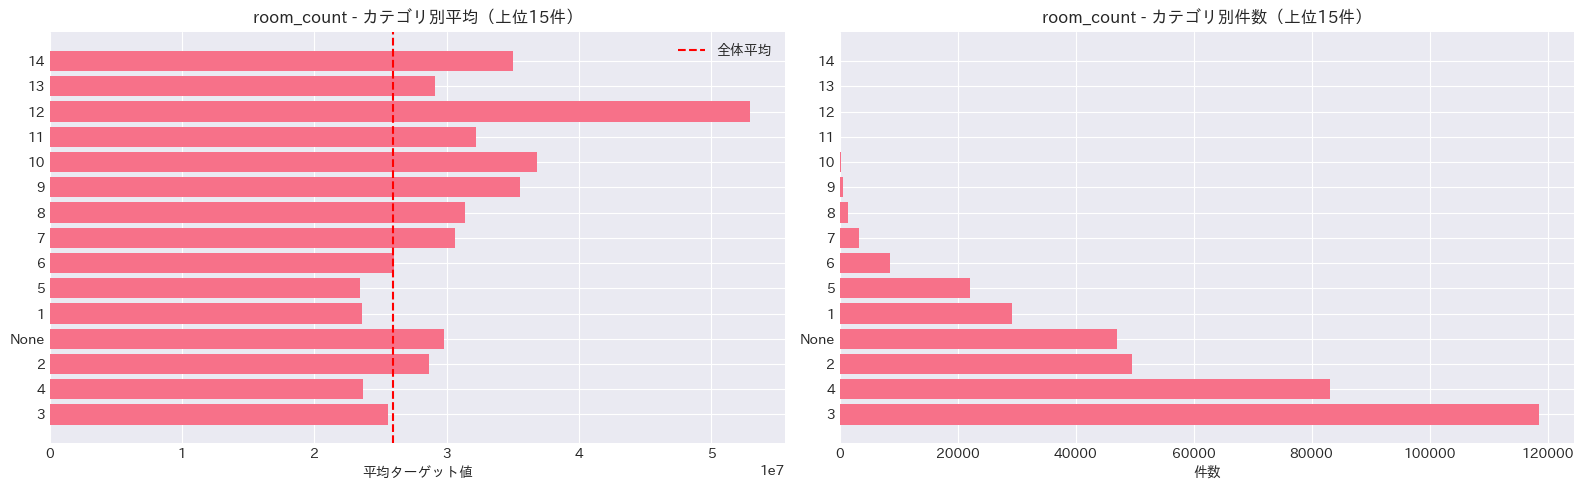


[madori_number_all - カテゴリ別ターゲット統計（上位15件）]
shape: (15, 4)
┌───────────────────┬────────┬─────────────┬────────────┐
│ madori_number_all ┆ count  ┆ mean_target ┆ std_target │
│ ---               ┆ ---    ┆ ---         ┆ ---        │
│ i64               ┆ u32    ┆ f64         ┆ f64        │
╞═══════════════════╪════════╪═════════════╪════════════╡
│ 3                 ┆ 138638 ┆ 2.6127e7    ┆ 1.7555e7   │
│ 4                 ┆ 92074  ┆ 2.4096e7    ┆ 1.5707e7   │
│ 2                 ┆ 58243  ┆ 2.9461e7    ┆ 2.1446e7   │
│ 1                 ┆ 33606  ┆ 2.4102e7    ┆ 1.7713e7   │
│ 5                 ┆ 25057  ┆ 2.3643e7    ┆ 1.9566e7   │
│ …                 ┆ …      ┆ …           ┆ …          │
│ 11                ┆ 155    ┆ 3.8976e7    ┆ 3.9980e7   │
│ 12                ┆ 82     ┆ 4.8418e7    ┆ 4.3573e7   │
│ 13                ┆ 61     ┆ 4.1833e7    ┆ 4.5439e7   │
│ 14                ┆ 16     ┆ 3.7090625e7 ┆ 3.0466e7   │
│ 16                ┆ 6      ┆ 5.0167e7    ┆ 1.8670e7   │
└─────────────

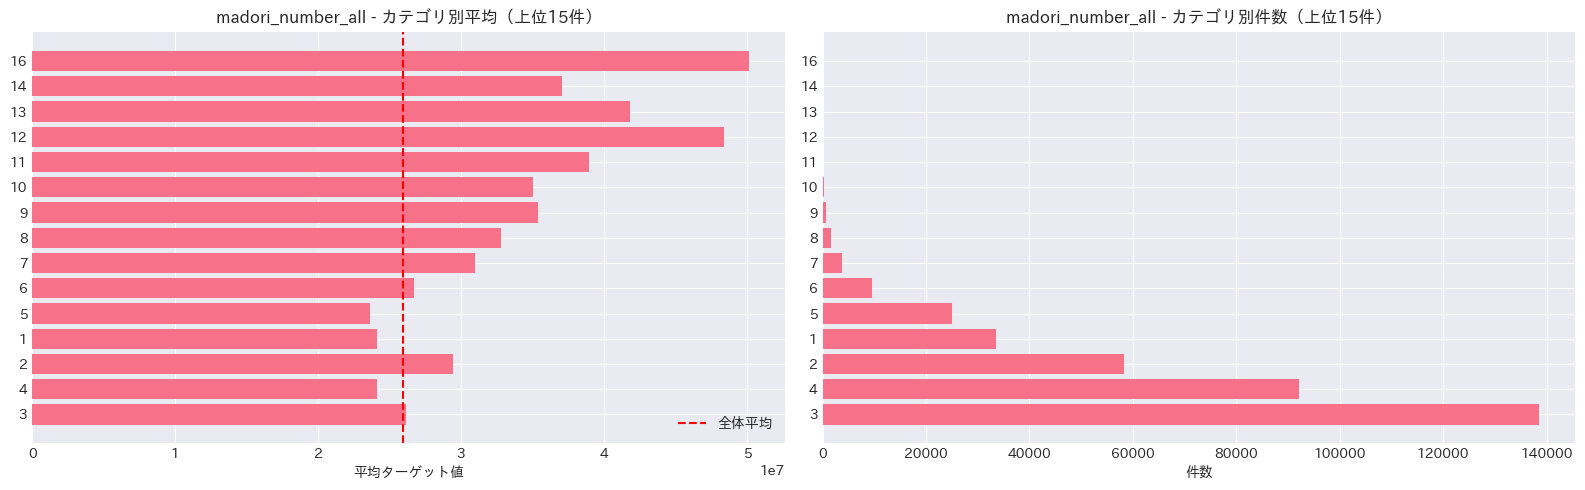


[reform_exterior - カテゴリ別ターゲット統計（上位15件）]
shape: (7, 4)
┌─────────────────┬────────┬─────────────┬────────────┐
│ reform_exterior ┆ count  ┆ mean_target ┆ std_target │
│ ---             ┆ ---    ┆ ---         ┆ ---        │
│ str             ┆ u32    ┆ f64         ┆ f64        │
╞═════════════════╪════════╪═════════════╪════════════╡
│ null            ┆ 347241 ┆ 2.6103e7    ┆ 1.8702e7   │
│ 2               ┆ 6844   ┆ 2.2327e7    ┆ 1.4947e7   │
│ 2/1             ┆ 4522   ┆ 2.0224e7    ┆ 1.1399e7   │
│ 1/2             ┆ 4329   ┆ 2.3826e7    ┆ 1.7343e7   │
│ 1               ┆ 985    ┆ 2.3520e7    ┆ 1.9836e7   │
│ 1               ┆ 2      ┆ 2.38e7      ┆ 0.0        │
│ 2/              ┆ 1      ┆ 6.98e7      ┆ null       │
└─────────────────┴────────┴─────────────┴────────────┘


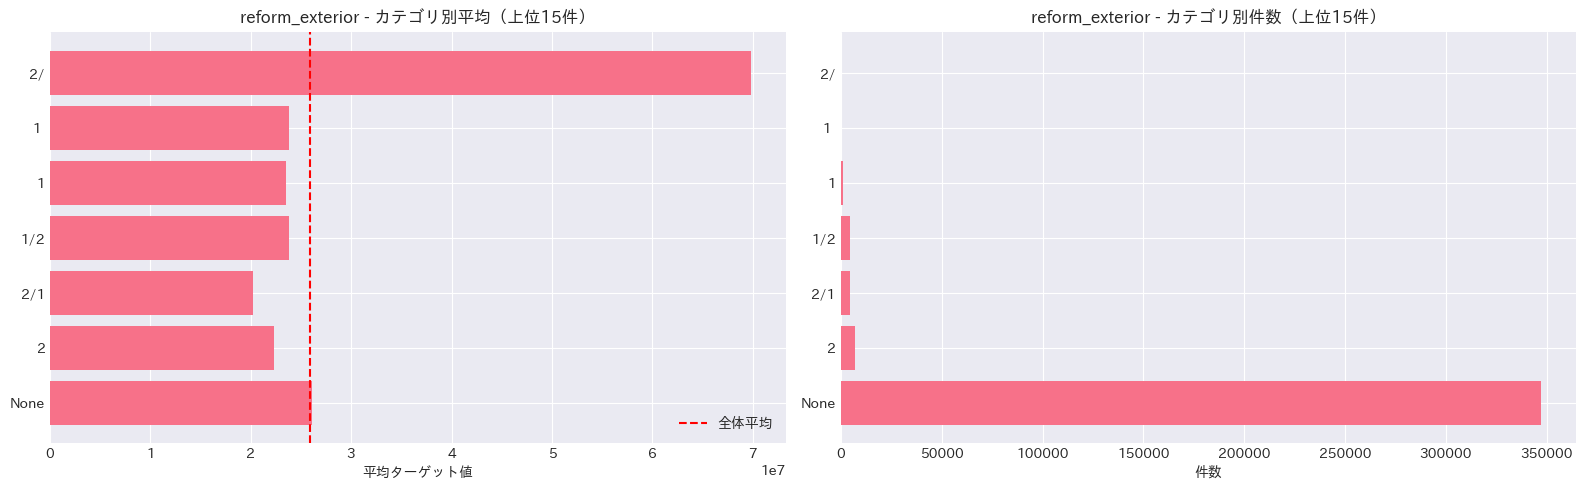

In [6]:
# Target Encoding効果が高い上位3カラムで詳細分析
top_3_cols = [col for col, _, _ in te_potentials[:3]]

for col in top_3_cols:
    # カテゴリ別統計量を取得（テスト済み関数）
    stats = get_category_target_stats(train, col, target_col, top_n=15)
    
    print(f"\n[{col} - カテゴリ別ターゲット統計（上位15件）]")
    print(stats)
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # 平均値のバープロット
    categories = stats[col].to_list()
    means = stats['mean_target'].to_list()
    
    ax1.barh(range(len(categories)), means)
    ax1.set_yticks(range(len(categories)))
    ax1.set_yticklabels([str(c)[:30] for c in categories])
    ax1.set_xlabel('平均ターゲット値')
    ax1.set_title(f'{col} - カテゴリ別平均（上位15件）')
    ax1.axvline(x=train[target_col].mean(), color='r', linestyle='--', label='全体平均')
    ax1.legend()
    
    # 件数のバープロット
    counts = stats['count'].to_list()
    
    ax2.barh(range(len(categories)), counts)
    ax2.set_yticks(range(len(categories)))
    ax2.set_yticklabels([str(c)[:30] for c in categories])
    ax2.set_xlabel('件数')
    ax2.set_title(f'{col} - カテゴリ別件数（上位15件）')
    
    plt.tight_layout()
    plt.show()

## 6. まとめ

### カーディナリティ
- **低カーディナリティ**: X件 → One-Hot Encodingが適用可能
- **中カーディナリティ**: Y件 → Target Encodingが有効
- **高カーディナリティ**: Z件 → Frequency EncodingやLeave-One-Out Encodingを検討

### Target Encoding候補
- **効果が高い特徴量**: [リスト]
- **注意点**: 
  - 過学習を防ぐためクロスバリデーションでエンコード
  - テストデータに未知カテゴリがある場合の対策が必要

### 次のステップ
- [ ] 地理空間分析（05_geospatial_analysis.ipynb）
- [ ] カテゴリエンコーディングの実装
- [ ] 特徴量エンジニアリング